# Introduction
## Context
You are a brand new People & Culture Specialist for a US-based Silicon Valley Tech Startup. The company received a hefty startup capital and you've been tasked with setting up the perfect environment for potential employees. One important element is **well-being** in the form of health benefits and setting up a work culture that each employee can feel comfortable in. Furthermore, you want to **upkeep a high eNPS and retain top talent**. To gather insights on the state of mental health in the tech world, you will be using the [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry/data) dataset to derive insights on what you should focus on the most when building the perfect work environment.

## Approach
To get the most relatable responses, we will focus on analyzing the responses of **US-based tech/IT not self-employed workers**. The justification for this is as follows:
* US-based for the context (*US-based Silicon Valley Tech Startup*)
* Tech/IT for the industry
* Not self-employed for a better understanding of employee-company interaction

# Data Preparation
## Imports & Configuration

In [1]:
# Core Modules, Helper Functions & Database connection
import numpy as np
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Image

from utils import table_schema, table_head, state_iso_mapping, detailed_labels
from utils import two_pie_subplots, pie_chart

conn = sql.connect('data/mental_health.sqlite')

In [2]:
# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Charts' Color Palette
color_palette = sns.color_palette("colorblind")
sns.set_style("whitegrid", {'axes.grid' : False})

## Data Formatting & Cleaning
Let's take a look at the SQL tables and check whether the columns have the correct datatypes.

In [4]:
table_names = ["Survey", "Question", "Answer"]
for table_name in table_names:
    table_head(conn, table_name)
    table_schema(conn, table_name)
    print('\n')

Head of table Survey:
   SurveyID                    Description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019
Schema for table Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Head of table Question:
                                        questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5
Schema for table Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)


Head of table Answer:
  AnswerText  SurveyID  UserID  QuestionID
0        

The datatypes are properly assigned to each column. The generous 10 000 character limit for the `AnswerText` column should not cause any issues.

## Respondents' Demographics
Before we dive deep into the Mental Health analysis, let's review respondents' demographics. Since we are a US-based startup, we will only limit our analysis to **US-based respondents** to have the best representation of the challenges the workers may face and the benefits that they seek in the American tech job market.

In [5]:
# The following CTE will be used to filter only American respondents that
# have a role in tech/IT and are not self-employed.
query_US_tech = """
    WITH CompanyWorkers AS (
        SELECT UserID
        FROM Answer
        WHERE QuestionID = 5 AND AnswerText = '0'
    ),
    TechWorkers AS (
        SELECT UserID
        FROM Answer
        WHERE QuestionID = 13 AND AnswerText = '1' AND UserID IN CompanyWorkers
    ),
    AmericanUsers AS (
        SELECT UserID
        FROM Answer
        WHERE QuestionID = 3 AND AnswerText LIKE 'United States%' AND UserID IN TechWorkers
    )
"""

### Gender & Age Distribution

In [6]:
query = f"""
    {query_US_tech},
    AmericanUsersGenders AS (
    SELECT UserID,
    	CASE
    		WHEN AnswerText IN ('Male', 'male') THEN 'Male'
    		WHEN AnswerText IN ('Female', 'female') THEN 'Female'
    		ELSE 'Other'
    	END AS Gender
    FROM Answer
    WHERE QuestionID = 2 AND UserID IN AmericanUsers
    ),
    AmericanUsersAges AS (
        SELECT UserID,
    		CAST(AnswerText AS INTEGER) AS Age
    	FROM Answer
    	WHERE QuestionID = 1 AND UserID IN AmericanUsers
    ),
    AmericanUsersAgesGroups AS (
        SELECT UserID,
        CASE
            WHEN Age < 25 THEN 'Under 25 years old'
            WHEN Age >= 25 AND Age < 40 THEN '25-39 years old'
            WHEN Age >= 40 AND Age < 60 THEN '40-59 years old'
            ELSE '60 years old and above'
        END AS Age_Group
        FROM AmericanUsersAges
    )
    SELECT Gender,
        Age_Group,
        COUNT(*) As Total
    FROM AmericanUsersGenders AS ag
    JOIN AmericanUsersAgesGroups AS aa
    ON ag.UserID=aa.UserID
    GROUP BY Gender, Age_Group
    ORDER BY Total DESC;
"""
survey_age = pd.read_sql_query(query, conn)

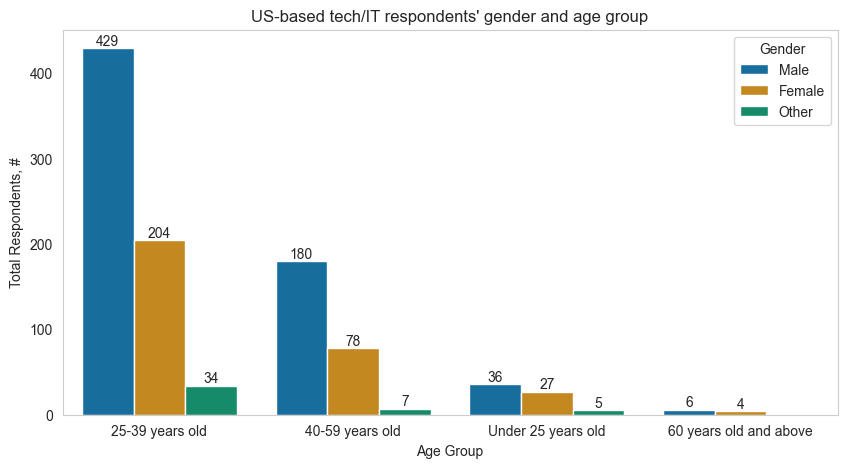

In [7]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=survey_age, x='Age_Group', y='Total', hue='Gender', palette=color_palette)
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("Age Group")
plt.ylabel("Total Respondents, #")
plt.title("US-based tech/IT respondents' gender and age group");

### Participants by State

In [8]:
query = f"""
    {query_US_tech}
    SELECT AnswerText AS State,
           COUNT(*) AS Participants
    FROM Answer
    WHERE QuestionID = 4 AND AnswerText != '-1' AND UserID IN AmericanUsers
    GROUP BY AnswerText
    ORDER BY Participants DESC;
"""
survey_state = pd.read_sql_query(query, conn)
survey_state['ISO_Code'] = survey_state['State'].map(state_iso_mapping)

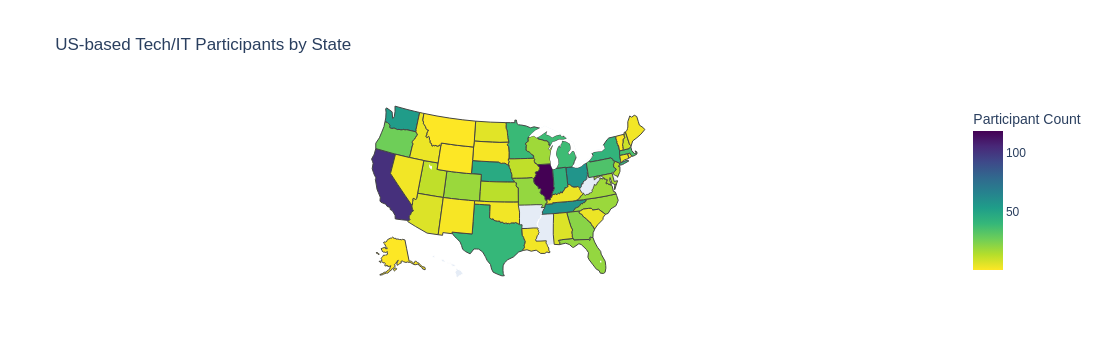

In [9]:
fig = px.choropleth(
    survey_state,
    locations='ISO_Code',
    color='Participants',
    locationmode='USA-states',
    scope='usa',
    color_continuous_scale='viridis_r',
    title='US-based Tech/IT Participants by State',
    labels={'Participants': 'Participant Count'}
)
fig.show();

# Plot Image for viewing through Github
Image(filename='media/US_participation.png')

### Work Type (On-site / Remote)

In [10]:
query = f"""
    {query_US_tech}
    SELECT AnswerText AS Remote_Work,
           COUNT(*) AS Answer_Count
    FROM Answer
    WHERE QuestionID = 118 AND UserID IN AmericanUsers
    GROUP BY Remote_Work
    ORDER BY Answer_Count DESC;
"""
remote_work = pd.read_sql_query(query, conn).groupby('Remote_Work')['Answer_Count'].sum()

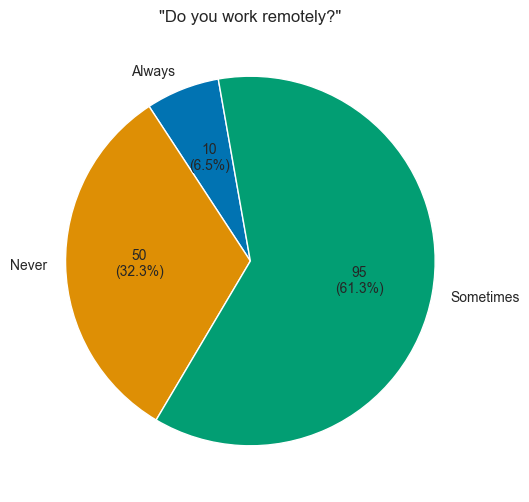

In [11]:
pie_chart(remote_work, '"Do you work remotely?"', color_palette)

The demograpghic analysis of the US-based Tech Workers respondents have given us some valuable insights!
* A large part of respondents are in their Mid-Career from ages 25-39, 64% of whom are **male**.
* Senior/Executive respondents are second, with a very similar 2-1 male to female split.
* Junior level respondents are third, with a close distribution between male and female respondents.
* Most responses came from Illinois and, luckily for us, from California.
* Majority of respondents have a Hybrid work model; A third has remote work.

## Mental Illnesses Analysis
Now that we have a better understanding of our survey sample, let's explore the what sorts of mental illnesses were specified by the respondents. This information will allow us to make workplace adjustments and tailor the benefits and support programs for the most prominent types of illnesses these workers face.

### List of Mental Illnesses
We'll split the mental illnesses into two categories: **Diagnosed** and **Assumed**, both of which are two different questions in the survey.

In [12]:
query = f"""
{query_US_tech}
SELECT
  CASE
    WHEN INSTR(AnswerText, '(') > 0 THEN TRIM(SUBSTR(AnswerText, 1, INSTR(AnswerText, '(') - 1))
    ELSE AnswerText
  END AS Disease,
  COUNT(*) AS Diagnosed
FROM Answer
WHERE QuestionID = 115 AND AnswerText != '-1' AND UserID IN AmericanUsers
GROUP BY Disease
ORDER BY Diagnosed DESC;
"""
df_diagnosed_disease = pd.read_sql_query(query, conn)

In [13]:
query = query.replace('QuestionID = 115', 'QuestionID = 116').replace('Diagnosed', 'Assumed')
df_assumed_disease = pd.read_sql_query(query, conn)

In [ ]:
# Merge the two DataFrames and melt it for visualization
df_disease_merged = pd.merge(df_diagnosed_disease, df_assumed_disease, on='Disease', how='outer')
df_disease_merged['Diagnosed'].fillna(0, inplace=True)
df_disease_merged['Assumed'].fillna(0, inplace=True)
df_disease_merged['Total'] = df_disease_merged['Diagnosed'] + df_disease_merged['Assumed']
df_disease_merged = df_disease_merged.sort_values(by='Total', ascending=False)
df_disease_merged.set_index('Disease', inplace=True)
df_disease_merged_ex_total_top10 = df_disease_merged.drop('Total', axis=1)[:9]

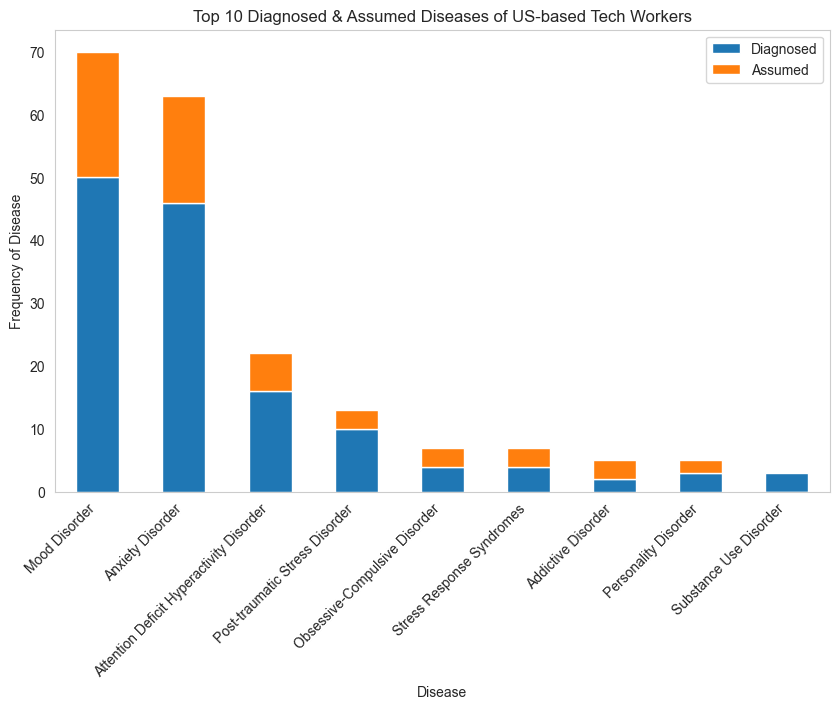

In [15]:
ax = df_disease_merged_ex_total_top10.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Disease')
ax.set_ylabel('Frequency of Disease')
ax.set_title('Top 10 Diagnosed & Assumed Diseases of US-based Tech Workers');

We can derive the following highlights from the visual:
* The majority of our target sample are diagnosed with **Mood Disorders** (Depression, Bipolar Disorder, etc) and **Anxiety Disorders** (Generalized, Social, Phobia, etc).
* Assumed Disorders follow a similar trend - the two biggest categories are the same.
* ADHD is third on the list; A very diruptive disease when it comes to concentration.

Let's explore whether the target sample believes that the diseases impact their work. For the sake of simplicity, let's group the `Diagnosed` and `Assumed` counts together.

### Impact to work quality of effectively & non-effectively treated diseases

In [16]:
query = f"""
    {query_US_tech},
    AmericanDiseases AS (
	SELECT UserID,
	CASE
        WHEN INSTR(AnswerText, '(') > 0 THEN TRIM(SUBSTR(AnswerText, 1, INSTR(AnswerText, '(') - 1))
    	ELSE AnswerText
  	END AS Disease
  	FROM Answer
	WHERE QuestionID = 115 AND AnswerText != '-1' AND UserID IN AmericanUsers
    ),
    AmericanDiseaseTreated AS (
    	SELECT UserID,
    	       AnswerText AS ProductivityImpact
    	FROM Answer
    	WHERE QuestionID = 48 AND UserID IN AmericanUsers
    ),
    DiseaseImpact AS (
    	SELECT UserID,
    	CASE
    		WHEN ProductivityImpact = 'Never' THEN 0
    		WHEN ProductivityImpact = 'Rarely' THEN 0.2
    		WHEN ProductivityImpact = 'Sometimes' THEN 0.5
    		WHEN ProductivityImpact = 'Often' THEN 0.8
            WHEN ProductivityImpact = 'Always' THEN 1
    	ELSE 0
    	END AS ProductivityImpactRating
    	FROM AmericanDiseaseTreated
    )
    SELECT ad.Disease,
           ROUND(AVG(adt.ProductivityImpactRating), 2) AS ProductivityImpactTreated
    FROM AmericanDiseases AS ad
    JOIN DiseaseImpact AS adt
    ON ad.UserID=adt.UserID
    GROUP BY ad.Disease;
"""
df_disease_treated = pd.read_sql_query(query, conn)

In [17]:
query = query.replace('QuestionID = 48', 'QuestionID = 49')
query = query.replace('AmericanDiseaseTreated', 'AmericanDiseaseUntreated')
query = query.replace('ProductivityImpactTreated', 'ProductivityImpactUntreated')
df_disease_untreated = pd.read_sql_query(query, conn)

In [18]:
df_disease_impact = pd.merge(df_disease_merged, df_disease_treated, on='Disease', how='inner')
df_disease_impact = pd.merge(df_disease_impact, df_disease_untreated, on='Disease', how='inner')
melted_df = pd.melt(df_disease_impact, id_vars=['Disease'],
                    value_vars=['ProductivityImpactTreated', 'ProductivityImpactUntreated'],
                    var_name='TreatmentType', value_name='ProductivityImpact')

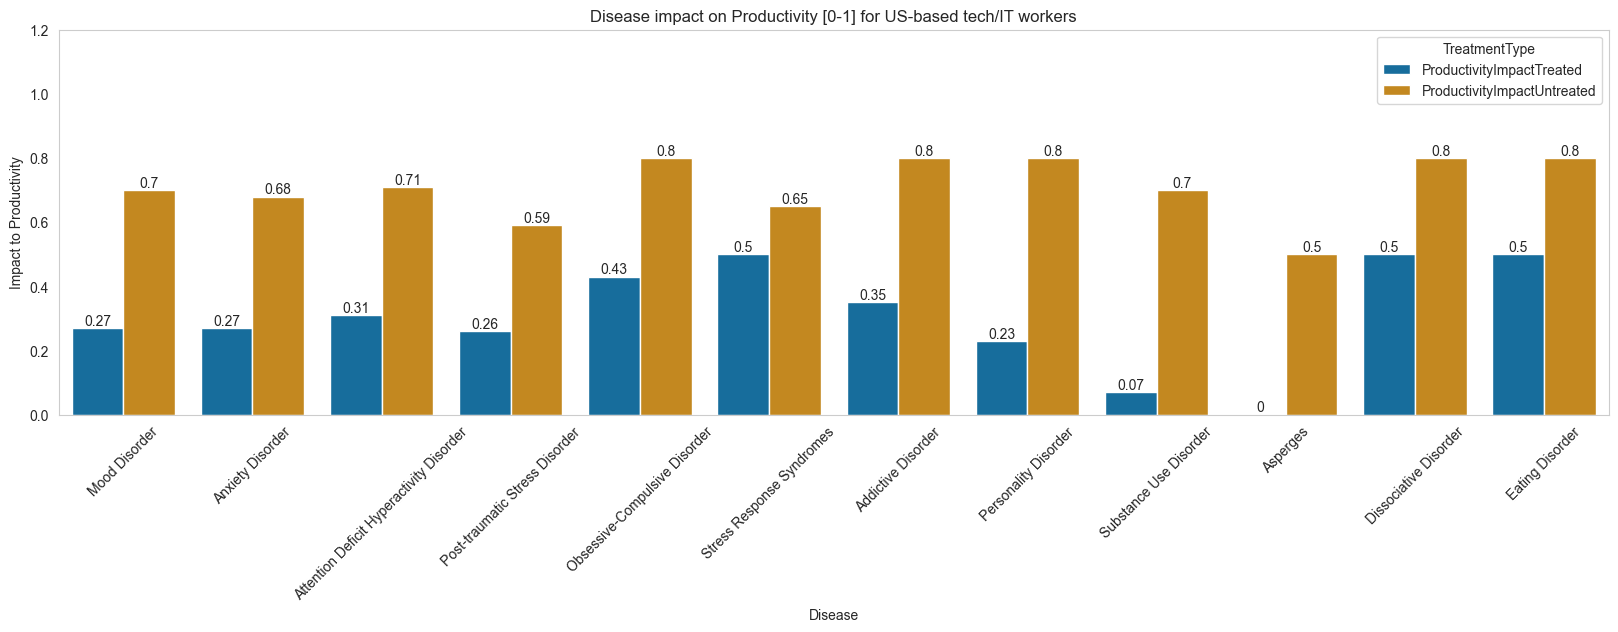

In [19]:
plt.figure(figsize=(20, 5))
ax = sns.barplot(data=melted_df, x='Disease', y='ProductivityImpact', hue='TreatmentType', palette=color_palette)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.ylim(0, 1.2)
plt.xlabel("Disease")
plt.ylabel("Impact to Productivity")
plt.title("Disease impact on Productivity [0-1] for US-based tech/IT workers");

Quite understandably, untreated mental disease seems to have a bigger toll on workers' productivity. Let's note the following for our previously discussed diseases:
* All identified diseases that are untreated have an impact of or above "Sometimes".
* Mood and Anxiety disorders, the mental health issues that our sample seems to identify with the most, have almost have an equal impact on productivity in treated and untreated cases. The untreated cases have an impact between "Sometimes" and "Often".
* ADHD shows a very similar situation, with a slightly higher treated impact to productivity.
* Personality, Addictive and Substance Use disorders have the largest gap between untreated and treated impacts, and the resources to help manage these disorders should definitely be considered for workers.

## Mental Health Benefits and Resources for Employees
We have a pretty good understanding on our target demographics and the mental health disorders that they may face. Let's explore whether the respondents are aware of wellness programs and resources that companies may provide.

### Mental Health-related expenses coverage

In [20]:
query = f"""
    {query_US_tech}
    SELECT AnswerText,
           COUNT(*) AS Frequency
    FROM Answer
    WHERE QuestionID = 10 AND UserID IN AmericanUsers
    GROUP BY AnswerText;
"""

mental_benefits = pd.read_sql_query(query, conn).groupby('AnswerText')['Frequency'].sum()

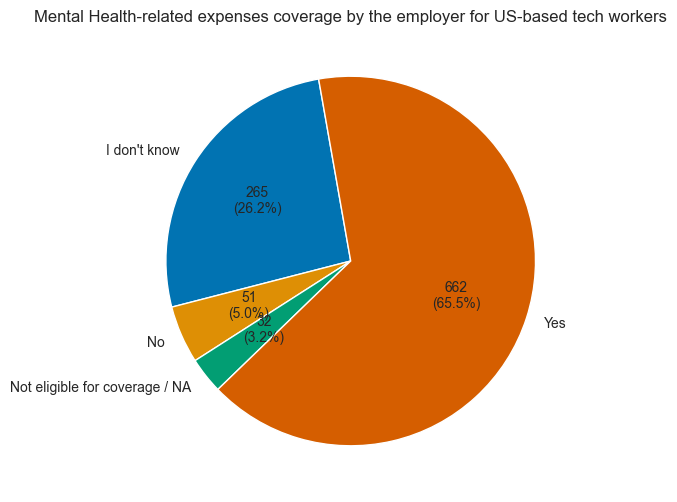

In [21]:
pie_chart(mental_benefits, 'Mental Health-related expenses coverage by the employer for US-based tech workers',
          color_palette)

More than half of our target sample claims to have coverage! However, a concerning statistic is more than a quarter of respondents that indicated that they do not know whether they have the coverage or not. A follow-up question is to see whether the companies provide additional resources and proper communication for maintaining proper mental health.

### Resources and Communication of Mental Health importance

In [22]:
query = f"""
    {query_US_tech}
    SELECT AnswerText,
           COUNT(*) AS Frequency
    FROM Answer
    WHERE QuestionID = 16 AND UserID IN AmericanUsers
    GROUP BY AnswerText;
"""

mental_resources = pd.read_sql_query(query, conn).groupby('AnswerText')['Frequency'].sum()

In [23]:
query = query.replace("QuestionID = 16", "QuestionID = 15")
mental_communication = pd.read_sql_query(query, conn).groupby('AnswerText')['Frequency'].sum()

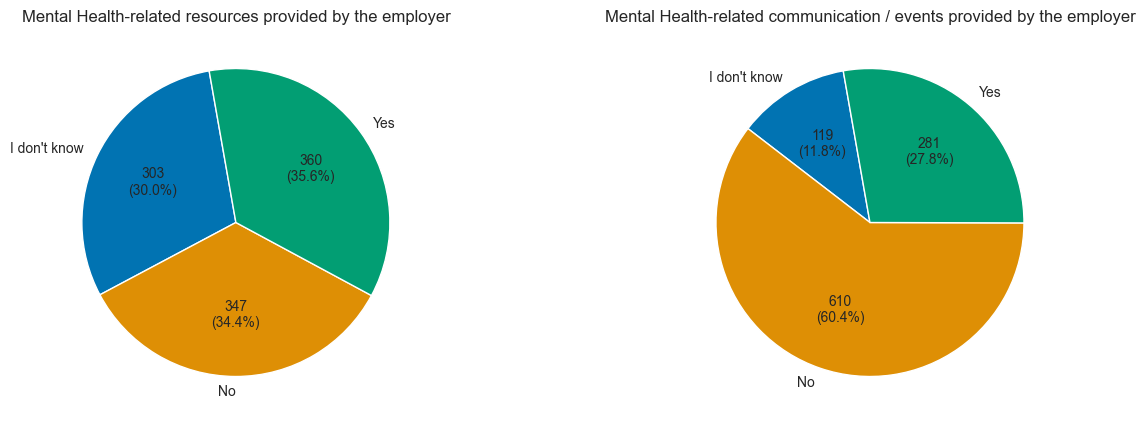

In [24]:
two_pie_subplots(mental_resources, mental_communication,
                 "Mental Health-related resources provided by the employer",
                 "Mental Health-related communication / events provided by the employer",
                 color_palette)

A recurring trend is visible among the two pie charts:
* Roughly **a third** of the respondents' companies are actively communicating the importance of Mental Health through providing resources or organizing events.
* A third of the respondents do not know whether they are eligible for Mental Health-related resources, while another third do not have them.

In essence, two-thirds of the respondents' companies do not place enough importance on providing or communicating the resources for the employees to take care of their mental health. Let's take a look at how the respondents believe that employers treat physical and mental health differently.

### How Employers value Physical and Mental Health

In [25]:
query = f"""
    {query_US_tech}
    SELECT CAST(AnswerText AS integer) AS Rating
    FROM Answer
    WHERE QuestionID = 64 AND UserID IN AmericanUsers;
"""

physical_health_rating = pd.read_sql_query(query, conn)
physical_health_rating['Category'] = 'Physical'
mental_health_rating = pd.read_sql_query(query.replace("QuestionID = 64", "QuestionID = 65")
                                              .replace("Physical", "Mental"), conn)
mental_health_rating['Category'] = 'Mental'

merged_df = pd.concat([physical_health_rating, mental_health_rating], axis=0, ignore_index=True)

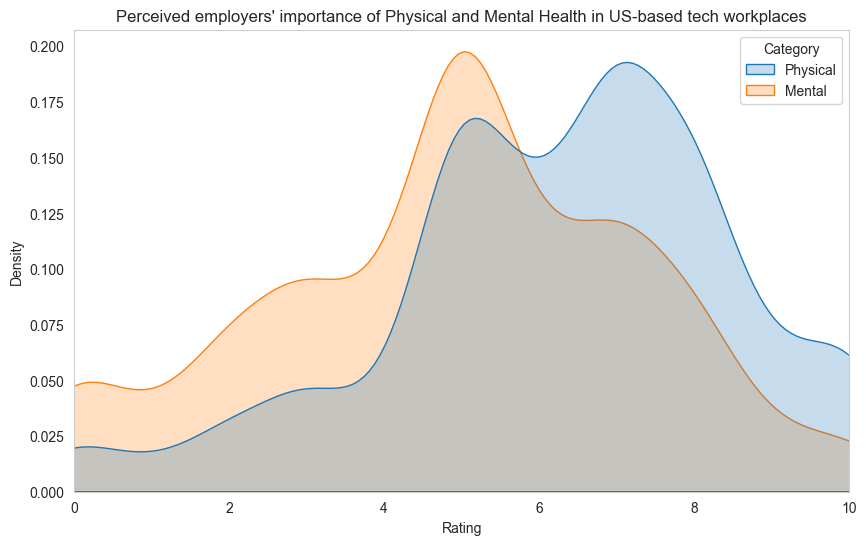

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='Rating', hue='Category', common_norm=False, fill=True)
plt.xlim(0, 10)
plt.xlabel("Rating")
plt.ylabel("Density")
plt.title("Perceived employers' importance of Physical and Mental Health in US-based tech workplaces")
plt.show();

In [27]:
health_summary = merged_df.groupby('Category').agg(
        Mean=('Rating', 'mean'),
        Percentile25=('Rating', lambda x: x.quantile(0.25)),
        Percentile75=('Rating', lambda x: x.quantile(0.75))
).reset_index()
health_summary['Mean'] = health_summary['Mean'].round(2)
health_summary['Interquartile Range'] = health_summary['Percentile75'] - health_summary['Percentile25']
health_summary

,Category,Mean,Percentile25,Percentile75,Interquartile Range
0,Mental,4.92,3.0,7.0,4.0
1,Physical,6.25,5.0,8.0,3.0


The respondents believe that employers think of physical health as more important than mental health. The higher mean, larger 75th Percentile and a narrower IQR for Physical health provide sufficient evidence for this claim. To be sure, let's see how employees perceive the difficulty of getting a Mental Health-related medical leave. 

In [28]:
query = f"""
    {query_US_tech}
    SELECT AnswerText,
           COUNT(*) AS Frequency
    FROM Answer
    WHERE QuestionID = 17 AND UserID IN AmericanUsers
    GROUP BY AnswerText
    ORDER BY Frequency DESC;
"""
medical_leave = pd.read_sql_query(query, conn).groupby('AnswerText')['Frequency'].sum()

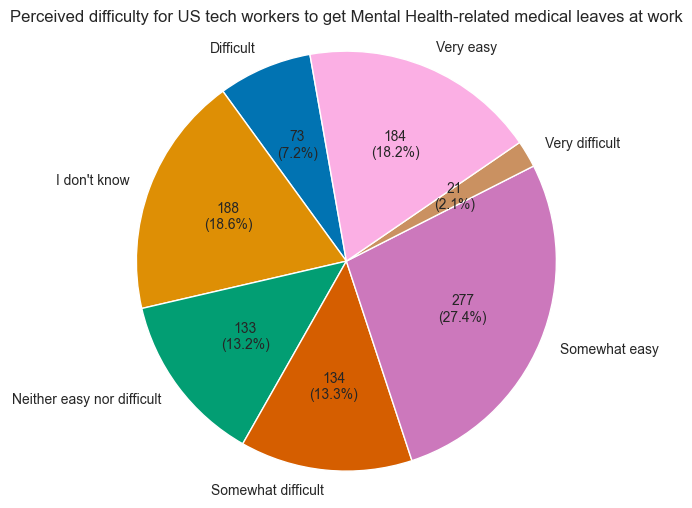

In [29]:
plt.figure(figsize=(8, 6))
plt.pie(medical_leave, labels=medical_leave.index, autopct=lambda pct: detailed_labels(pct, medical_leave),
        startangle=100, colors=color_palette)
plt.title('Perceived difficulty for US tech workers to get Mental Health-related medical leaves at work')
plt.axis('equal')
plt.show();

If we tally up the results, we get the following insights:
* Almost half believe that getting a medical leave would be easy.
* A quarter believe that it would be difficult.
* The rest are undecided.

An important addition to our own communication plan is to ensure that employees are aware of the possibility to take a Mental Health-related medical leave

## The culture of discussing Mental Health
### Discussing Mental Health with Others
Let's take a quick look on how open the employees are on discussing their mental health-related issues at the workplace to formulate our own approach better.

In [30]:
query = f"""
    {query_US_tech}
    SELECT AnswerText,
           COUNT(*) AS Frequency
    FROM Answer
    WHERE QuestionID = 18 AND UserID IN AmericanUsers
    GROUP BY AnswerText
    ORDER BY Frequency DESC;
"""
discuss_coworker = pd.read_sql_query(query, conn).groupby('AnswerText')['Frequency'].sum()
discuss_employer = pd.read_sql_query(query.replace('QuestionID = 18', 'QuestionID = 19'), conn).groupby('AnswerText')['Frequency'].sum()

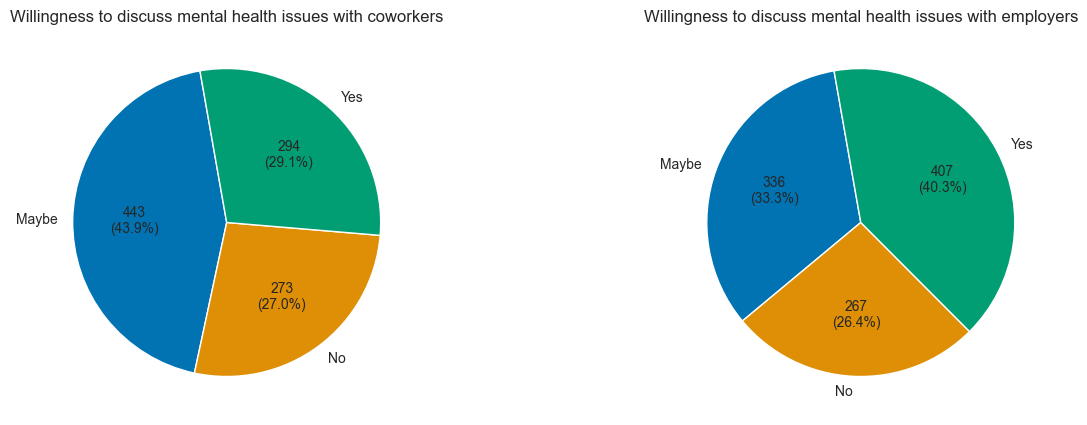

In [31]:
two_pie_subplots(discuss_coworker, discuss_employer,
                 "Willingness to discuss mental health issues with coworkers",
                 "Willingness to discuss mental health issues with employers",
                 color_palette)

* More employees are willing to discuss mental health issues with their employers, rather than coworkers;
* In both cases, the percentage of those who would not want to discuss mental health is similar.
* Almost half of employees are unsure on whether they would like to discuss mental health with their coworkers or not.

This prompts us to ensure that employers are trained to have proper discussions with employees regarding mental health, as the latter would be more likely to reach out to them first.

# Conclusion

## The Mental Health Plan
We've gathered a lot of insightful information on what to focus on for our communication, culture and mental health benefits strategy. Let's summarize our findings:
* Mood, Anxiety disorders and ADHD are the most prevalent mental health issues a worker might face. Communication plans and resources **must** have these disorders as a centerpiece. Personality, Addictive and Substance Use disorders have a severe impact to productivity when untreated; With treatment, however, these diseases are less impactful to productive work, therefore, they should also be included in our resources package.
* In a lot of cases, work productivity is impacted as much as three times when the disorder is not treated. Investments in the Mental Health benefits packages will pay off through improved employee productivity.
* A significant part of people in the IT/tech workforce may not be aware of the health benefits a company might be offering - make sure that the benefits are well-communicated.
* More than half of respondents noted that their workplaces do not host Mental Health-related events; This is a perfect opportunity to normalize the topic and garner employee engagement.
* In terms of communication, emphasize the importance of **both** physical and mental health.
* Make sure that the Mental Health benefits package includes the information regarding medical leave.
* Invest in training people managers on the topic of Mental Health; The employees are more likely to reach out to their supervisors regarding these topics.

## Considerations and Improvements for Future Studies
The dataset has provided many valuable insights on the mindset of IT/tech workers regarding Mental Health, a lot of which can be used by companies to adjust their own strategy in this regard.
Nonetheless, the following points should be considered:

The Publish date of the dataset (3 years ago)
Entirety of the data (Were any of the responses omitted by accident?)
Repetition of some questions
Furthermore, the following additions would help enhance the findings of future studies:
* Tenure in the IT/tech field
* Job position (Junior, Senior, Management, etc.)
* Methods on how each respondent deals with mental issues personally